In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-clustering/customer_segmentation.csv')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Check for missing data**

In [6]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

**There are 24 missing values in "Income" variable. We will replace it with its median.**

In [7]:
df['Income'].fillna(df['Income'].median(), inplace = True)

**Recheck missing values.**

In [8]:
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

**No missing values**

**"Dt_Customer" indicates the day particular customer registered with the firm. Check the newest and oldest recorded dates.**

In [9]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")
dates = []

for i in df['Dt_Customer']:
  i = i.date()
  dates.append(i)

#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


**Explore the unique values in the categorical features to get a clear idea of the data.**

In [10]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


**Calculate "Age" of a customer by the "Year_Birth".(indicating the birth year of the respective person.) We will calculate age till 2014. As we have data till 2014.**

In [11]:
df['Age_on_2014'] = 2014 - df['Year_Birth']

**Add new feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.**

In [12]:
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

**Created new feature "Living_with" out of "Marital_Status" to extract the living situation of couples.**

In [13]:
df['Living_with'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

**Add new feature "Children" to indicate total children in household (kid + Teen).**

In [14]:
df['Children'] = df['Kidhome'] + df['Teenhome']

**Add new feature "Family_size".**

In [15]:
df['Family_size'] = df['Living_with'].replace({"Alone": 1, "Partner": 2}) + df['Children']

**Add new feature "Is_parent" indicating parenthood status.**

In [16]:
df['Is_parent'] = np.where(df.Children > 0, 1, 0)

**Simplify values of "Education". (In three groups)**

In [17]:
df['Education'] = df['Education'].replace({"Basic":"Undergraduate", "2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [18]:
# For clarity
df =df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

**Drop Extra features.**

In [19]:
df = df.drop(columns = ['Marital_Status', 'Dt_Customer', 'ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue'], axis = 1)

In [20]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Living_with,Children,Family_size,Is_parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,57,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,60,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,49,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,30,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,33,422,Partner,1,3,1


In [21]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Children,Family_size,Is_parent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52237.975446,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,...,0.072768,0.064286,0.013393,0.009375,0.149107,45.194196,605.798214,0.950446,2.595089,0.715179
std,25037.955891,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,...,0.259813,0.245316,0.114976,0.096391,0.356274,11.984069,602.249288,0.751803,0.906959,0.451430
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,1.000000,0.000000
25%,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,68.750000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,396.000000,1.000000,3.000000,1.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,1045.500000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000,2525.000000,3.000000,5.000000,1.000000


**Clearly, there are few outliers in the "Income" and "Age_on_2014" feature. We will drop the outliers by setting a cap on Age and Income.**

In [22]:
df = df[(df["Age_on_2014"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2236


In [23]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age_on_2014',
       'Spent', 'Living_with', 'Children', 'Family_size', 'Is_parent'],
      dtype='object')

**Check Distribution of Data**

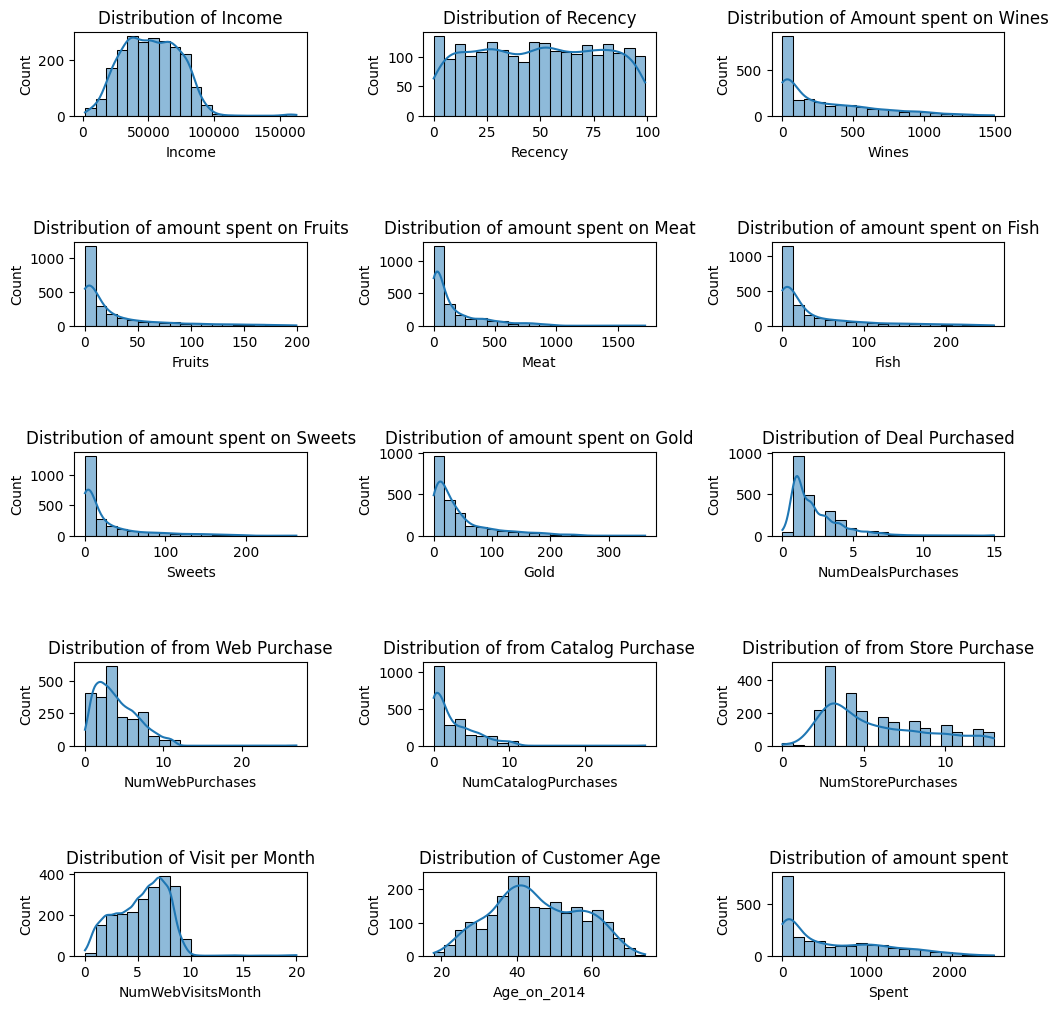

In [24]:
plt.figure(figsize = (12, 12))
plt.subplots_adjust(hspace = 1.5, wspace=0.5)

plt.subplot(5, 3, 1)
sns.histplot(df, x = 'Income', kde = True, bins = 20)
plt.title("Distribution of Income")

plt.subplot(5, 3, 2)
sns.histplot(df, x = 'Recency', kde = True, bins = 20)
plt.title("Distribution of Recency")

plt.subplot(5, 3, 3)
sns.histplot(df, x = "Wines", kde = True, bins = 20)
plt.title("Distribution of Amount spent on Wines")

plt.subplot(5, 3, 4)
sns.histplot(df, x = 'Fruits', kde = True, bins = 20)
plt.title("Distribution of amount spent on Fruits")

plt.subplot(5, 3, 5)
sns.histplot(df, x = 'Meat', kde = True, bins = 20)
plt.title("Distribution of amount spent on Meat")

plt.subplot(5, 3, 6)
sns.histplot(df, x = 'Fish', kde = True, bins = 20)
plt.title("Distribution of amount spent on Fish")

plt.subplot(5, 3, 7)
sns.histplot(df, x = 'Sweets', kde = True, bins = 20)
plt.title("Distribution of amount spent on Sweets")

plt.subplot(5, 3, 8)
sns.histplot(df, x = 'Gold', kde = True, bins = 20)
plt.title("Distribution of amount spent on Gold")

plt.subplot(5, 3, 9)
sns.histplot(df, x = 'NumDealsPurchases', kde = True, bins = 20)
plt.title("Distribution of Deal Purchased")

plt.subplot(5, 3, 10)
sns.histplot(df, x = 'NumWebPurchases', kde = True, bins = 20)
plt.title("Distribution of from Web Purchase")

plt.subplot(5, 3, 11)
sns.histplot(df, x = 'NumCatalogPurchases', kde = True, bins = 20)
plt.title("Distribution of from Catalog Purchase")

plt.subplot(5, 3, 12)
sns.histplot(df, x = 'NumStorePurchases', kde = True, bins = 20)
plt.title("Distribution of from Store Purchase")

plt.subplot(5, 3, 13)
sns.histplot(df, x = 'NumWebVisitsMonth', kde = True, bins = 20)
plt.title("Distribution of Visit per Month")

plt.subplot(5, 3, 14)
sns.histplot(df, x = 'Age_on_2014', kde = True, bins = 20)
plt.title("Distribution of Customer Age")

plt.subplot(5, 3, 15)
sns.histplot(df, x = 'Spent', kde = True, bins = 20)
plt.title("Distribution of amount spent")

plt.show()

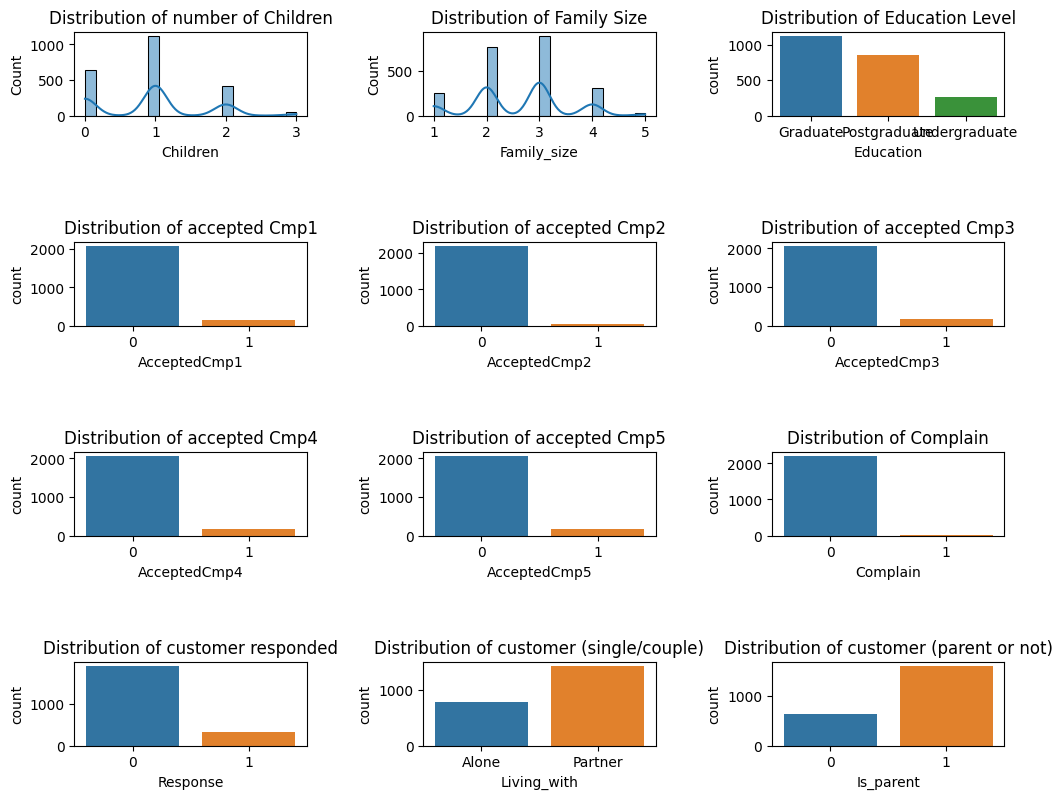

In [25]:
plt.figure(figsize = (12, 12))
plt.subplots_adjust(hspace = 1.5, wspace=0.5)

plt.subplot(5, 3, 1)
sns.histplot(df, x = 'Children', kde = True, bins = 20)
plt.title("Distribution of number of Children")

plt.subplot(5, 3, 2)
sns.histplot(df, x = 'Family_size', kde = True, bins = 20)
plt.title('Distribution of Family Size')

plt.subplot(5, 3, 3)
sns.countplot(df, x = 'Education')
plt.title("Distribution of Education Level")

plt.subplot(5, 3, 4)
sns.countplot(df, x = 'AcceptedCmp1')
plt.title("Distribution of accepted Cmp1")

plt.subplot(5, 3, 5)
sns.countplot(df, x = 'AcceptedCmp2')
plt.title("Distribution of accepted Cmp2")

plt.subplot(5, 3, 6)
sns.countplot(df, x = 'AcceptedCmp3')
plt.title("Distribution of accepted Cmp3")

plt.subplot(5, 3, 7)
sns.countplot(df, x = 'AcceptedCmp4')
plt.title("Distribution of accepted Cmp4")

plt.subplot(5, 3, 8)
sns.countplot(df, x = 'AcceptedCmp5')
plt.title("Distribution of accepted Cmp5")

plt.subplot(5, 3, 9)
sns.countplot(df, x = 'Complain')
plt.title('Distribution of Complain')

plt.subplot(5, 3, 10)
sns.countplot(df, x = 'Response')
plt.title('Distribution of customer responded')

plt.subplot(5, 3, 11)
sns.countplot(df, x = 'Living_with')
plt.title("Distribution of customer (single/couple)")

plt.subplot(5, 3, 12)
sns.countplot(df, x = 'Is_parent')
plt.title("Distribution of customer (parent or not)")

plt.show()

**From Distribution Plots, we can see that, Majority features are Right-skewed except Recency, Age and Family_size.**

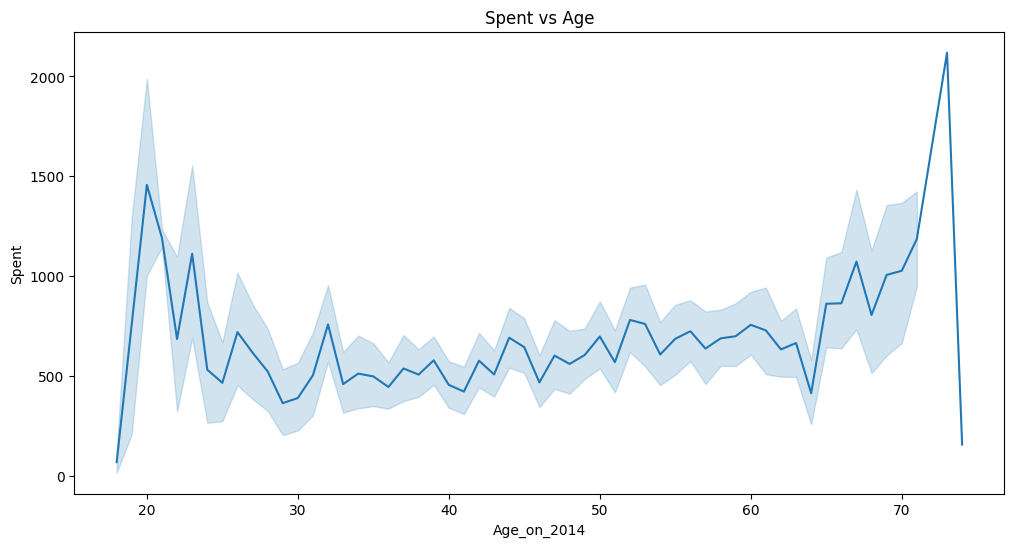


Correlation between Age_on_2014 and Spent: 0.11361767213727979


In [26]:
plt.figure(figsize = (12, 6))
sns.lineplot(df, x = 'Age_on_2014', y = 'Spent')
plt.title("Spent vs Age")
plt.show()
print(f"\nCorrelation between Age_on_2014 and Spent: {df['Age_on_2014'].corr(df['Spent'])}")

**From Spent vs Age plot, we can see that as Age increase, Spent also increases. Correlation score is 0.114.**

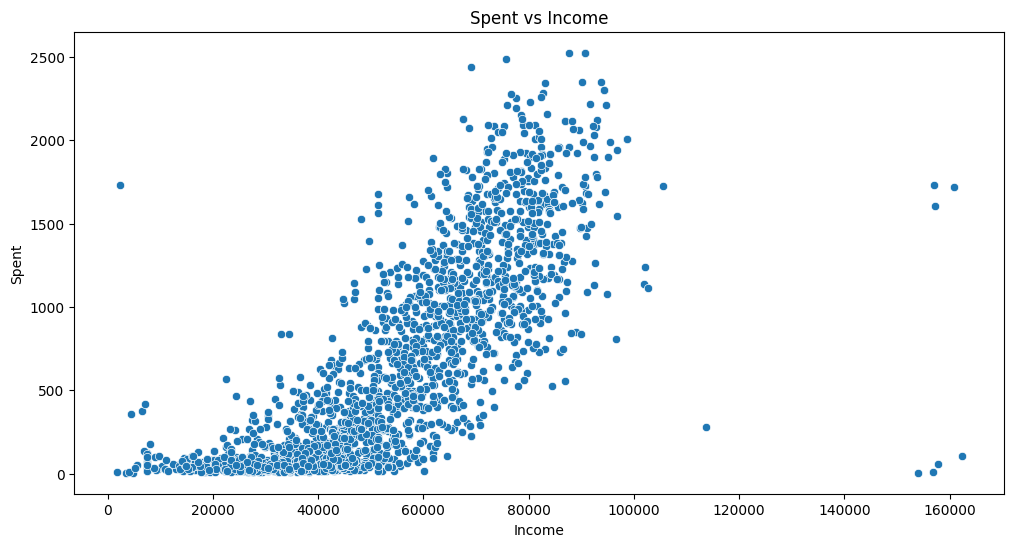


Correlation between Age_on_2014 and Spent: 0.7893749146446831


In [27]:
plt.figure(figsize = (12, 6))
sns.scatterplot(df, x = 'Income', y = 'Spent')
plt.title("Spent vs Income")
plt.grid(False)
plt.show()
print(f"\nCorrelation between Age_on_2014 and Spent: {df['Income'].corr(df['Spent'])}")

**Convert Categorical variables into Numerical Variables.**

In [28]:
# Check how many categorical variables are present in data
a = (df.dtypes == 'object')
object_cols = list(a[a].index)
print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_with']


In [29]:
# Convert to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
for i in object_cols:
  df[i] = df[[i]].apply(LE.fit_transform)

In [30]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Living_with,Children,Family_size,Is_parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,57,1617,0,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,60,27,0,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,49,776,1,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,30,53,1,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,33,422,1,1,3,1


**Check correlation amongst the features.**

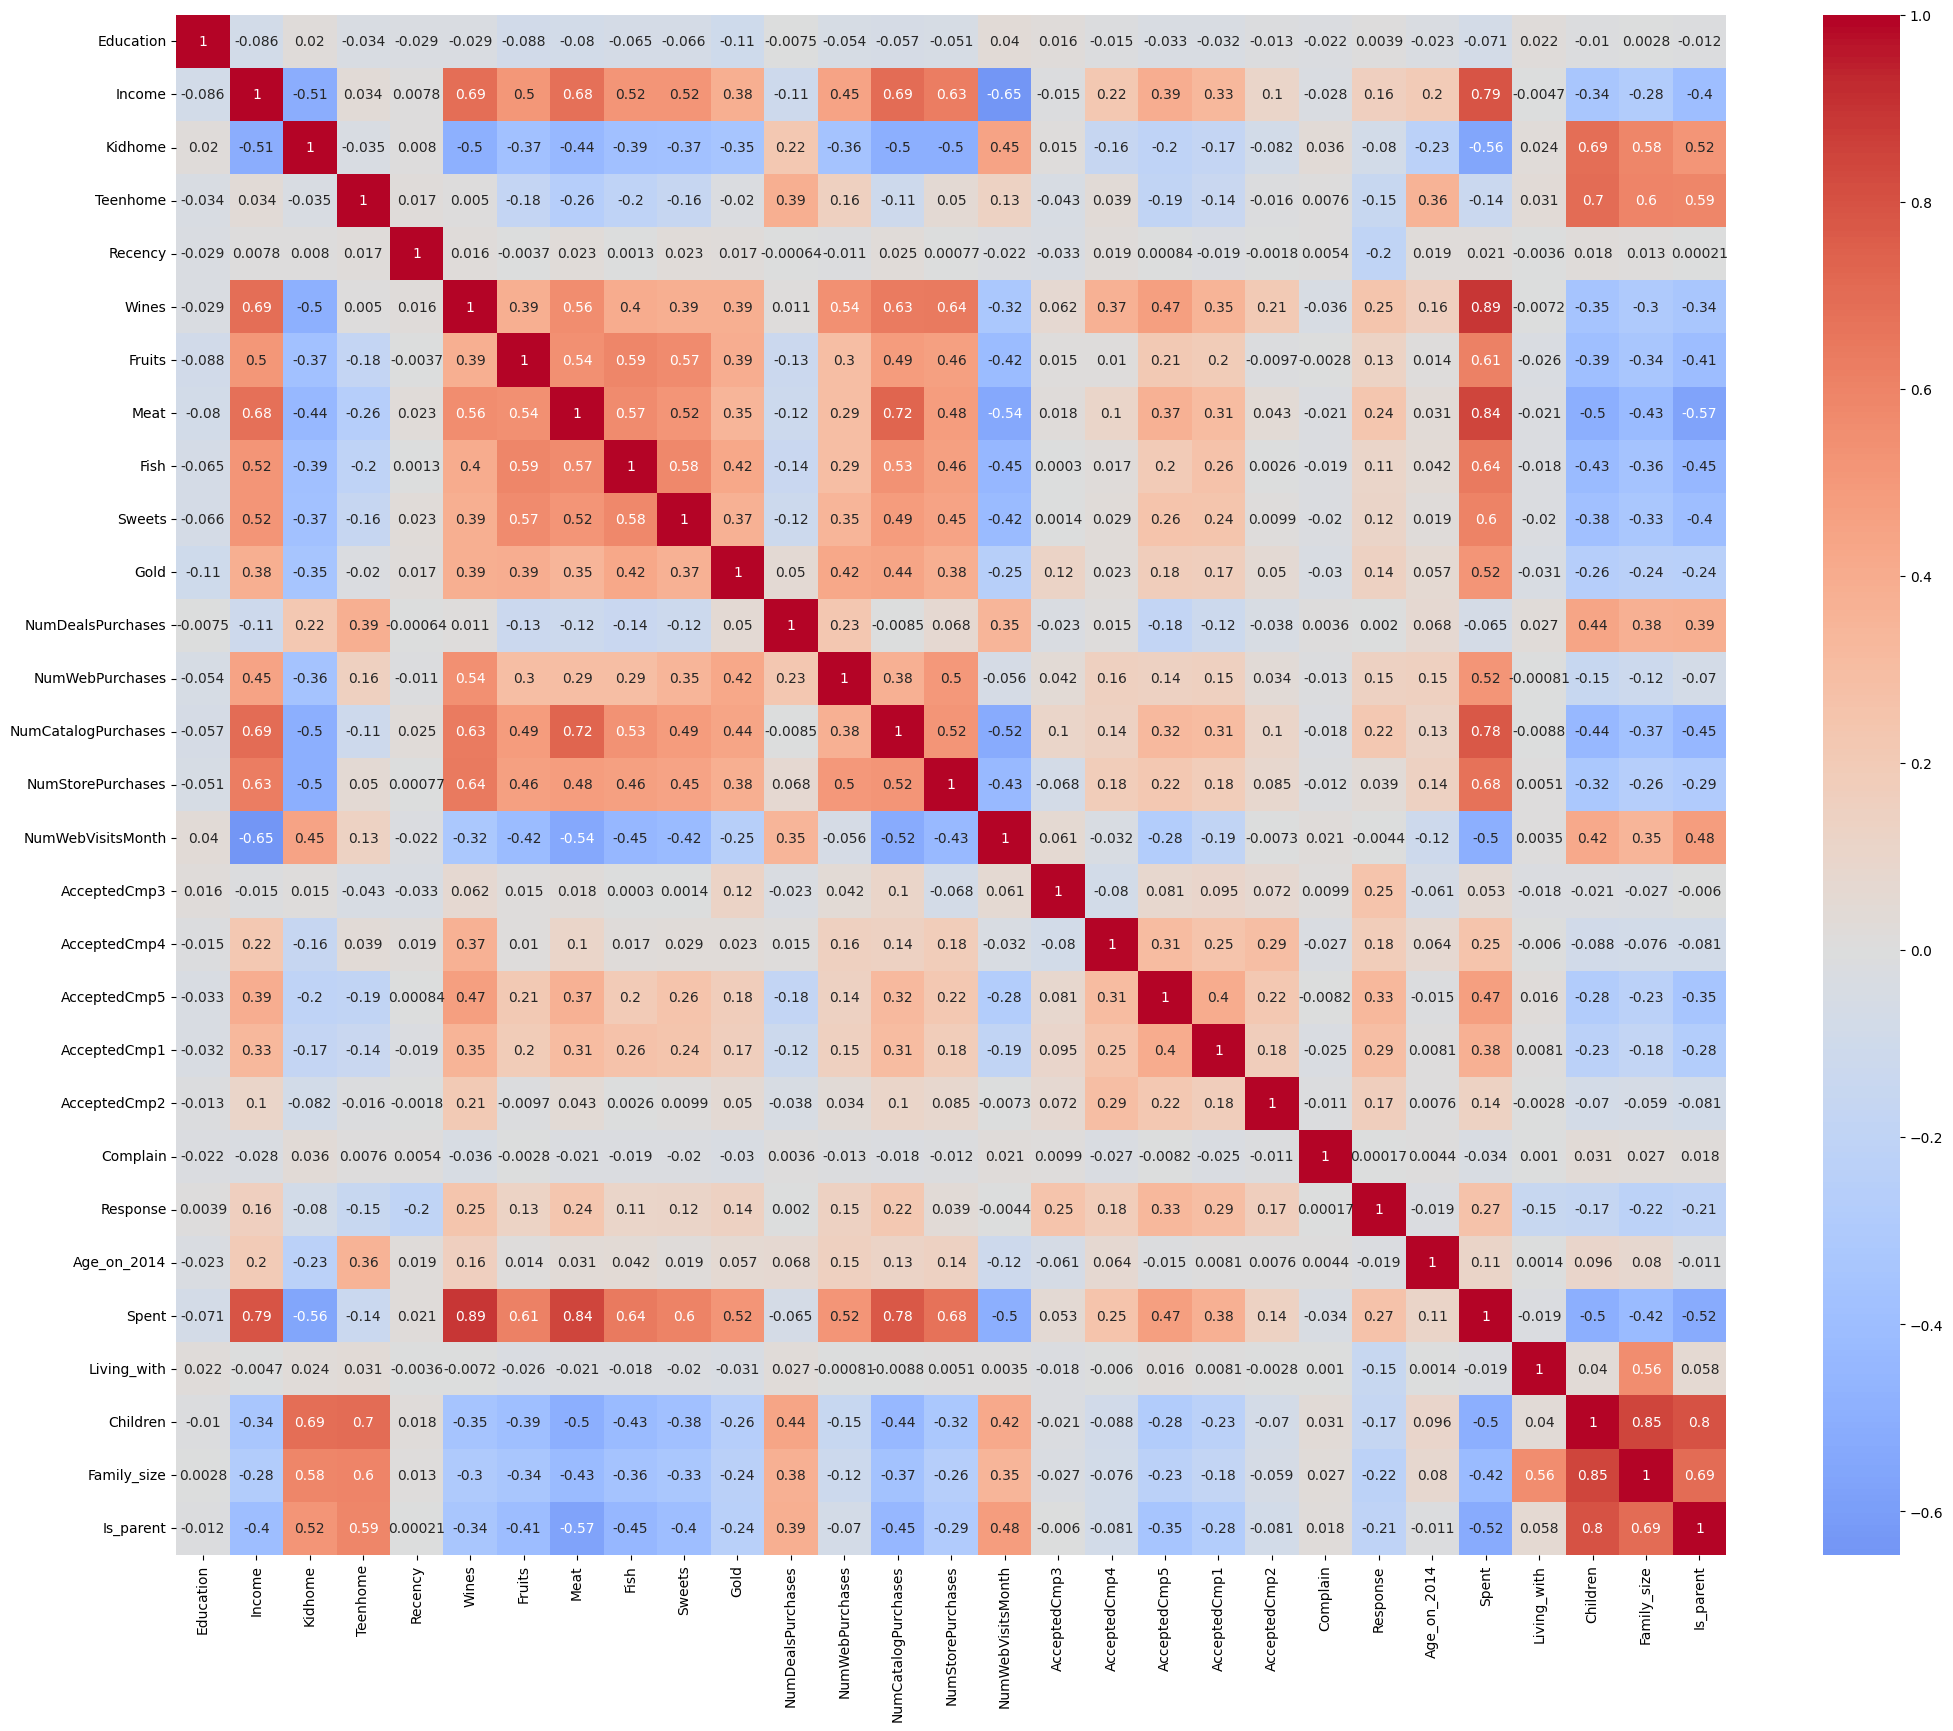

In [31]:
corrmax = df.corr()
plt.figure(figsize = (25, 20))
sns.heatmap(corrmax, annot = True, cmap = 'coolwarm', center = 0)
plt.show()

**Reduce Dimensions**

In [32]:
# Create a copy of data
df1 = df.copy()

**Scale the data before applying PCA**

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df1)
scaled_df1 = pd.DataFrame(scaler.transform(df1), columns = df1.columns)

In [34]:
scaled_df1

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Living_with,Children,Family_size,Is_parent
0,-0.89438,0.288947,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,...,-0.262362,-0.116616,-0.095001,2.386338,1.016868,1.680176,-1.347635,-1.264308,-1.758810,-1.584362
1,-0.89438,-0.262003,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,...,-0.262362,-0.116616,-0.095001,-0.419052,1.273264,-0.962202,-1.347635,1.395139,0.445618,0.631169
2,-0.89438,0.918423,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,...,-0.262362,-0.116616,-0.095001,-0.419052,0.333146,0.282541,0.742041,-1.264308,-0.656596,-1.584362
3,-0.89438,-1.182183,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.290693,-0.918994,0.742041,0.065416,0.445618,0.631169
4,0.57070,0.296187,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.034298,-0.305762,0.742041,0.065416,0.445618,0.631169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,-0.89438,0.433060,-0.824939,0.905974,-0.107640,1.203128,0.421101,0.066551,0.081700,2.201960,...,-0.262362,-0.116616,-0.095001,-0.419052,0.162216,1.221499,0.742041,0.065416,0.445618,0.631169
2232,0.57070,0.563440,2.890194,0.905974,0.237773,0.302727,-0.661610,-0.607091,-0.687019,-0.655857,...,3.811532,-0.116616,-0.095001,-0.419052,1.956986,-0.269201,0.742041,2.724862,2.650045,0.631169
2233,-0.89438,0.234898,-0.824939,-0.930615,1.446720,1.794481,0.546997,0.221666,-0.101329,-0.365231,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.034298,1.055312,-1.347635,-1.264308,-1.758810,-1.584362
2234,0.57070,0.807803,-0.824939,0.905974,-1.420212,0.368102,0.093769,0.208371,0.777208,0.070707,...,-0.262362,-0.116616,-0.095001,-0.419052,1.102333,0.393886,0.742041,0.065416,0.445618,0.631169


**Choosing the right number of dimensions**

Instead of arbitarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance - say, 95%.
* An exception to this rule, is if you are reducing dimensionality for data visualization, in which case you will want to reduce the dimensionality down to 2 or 3.

The following code peforms PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the variance.

In [35]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42, svd_solver = 'full')
pca.fit(scaled_df1)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [36]:
# Check how many minimum dimensions required to preserve 95% of the variance
d

21

**Alternate Method**

Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve.

In [37]:
pca = PCA(n_components = 0.95)
df1_reduced = pca.fit_transform(scaled_df1)
pca.n_components_

21

In [38]:
# Check cumsum  (Cummulative sum of variance)
cumsum

array([0.30085417, 0.40132626, 0.46709714, 0.51674336, 0.56437167,
       0.60231434, 0.63936162, 0.67372922, 0.70794208, 0.74075376,
       0.76890437, 0.79492988, 0.81957349, 0.84068678, 0.86155771,
       0.88104691, 0.89880421, 0.91502572, 0.930316  , 0.94496769,
       0.95811923, 0.96990969, 0.97923866, 0.98693678, 0.99382804,
       1.        , 1.        , 1.        , 1.        ])

In [39]:
# Check the cumsum of variance on 21st dimension
cumsum[21]

0.9699096877489255

**The variance at 21st principal component is approx 0.97. We can choose 19 dimensions as its total variance is around 0.95.**

In [40]:
cumsum[19]

0.9449676917314149

**Plot Dimensions vs Explained Variance**

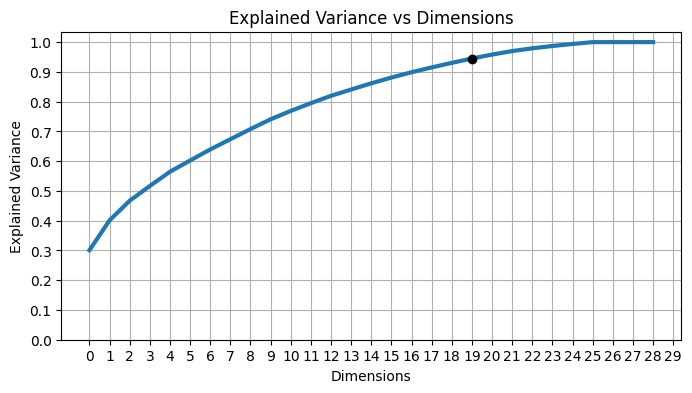

In [41]:
plt.figure(figsize = (8, 4))

plt.plot(cumsum, linewidth=3)

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Dimensions")
plt.plot(19, cumsum[19], "ko")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.show()

In [42]:
# Check Explained Variance at each dimensions
pca.explained_variance_ratio_

array([0.30085417, 0.10047209, 0.06577088, 0.04964623, 0.0476283 ,
       0.03794268, 0.03704728, 0.03436759, 0.03421287, 0.03281168,
       0.02815061, 0.02602551, 0.02464361, 0.02111329, 0.02087093,
       0.0194892 , 0.01775731, 0.01622151, 0.01529028, 0.01465169,
       0.01315154])

**Finally we will reduce original dataframe from 29 features to 19 features.**

In [43]:
# Initiating PCA to reduce dimensions aka features to 19
pca = PCA(n_components = 19, random_state = 42, svd_solver = 'full')
pca.fit(scaled_df1)
df1_reduced = pd.DataFrame(pca.transform(scaled_df1), columns = (['col1', 'col2', 'col3', 'col4',
                                                                  'col5', 'col6', 'col7', 'col8',
                                                                  'col9', 'col10', 'col11', 'col12',
                                                                  'col13', 'col14', 'col15', 'col16',
                                                                  'col17', 'col18', 'col19']))

**If we set svd_solver to 'Full', it will give slightly more precise result.**

In [44]:
df1_reduced

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,4.883005,-0.540530,-0.237962,2.412966,-1.344166,0.358375,0.653620,-0.279686,-0.134840,0.063301,-0.988261,-0.800622,2.535145,-1.078503,-0.284010,-0.137904,-0.396149,-0.746086,0.325545
1,-2.886862,0.209002,-0.181145,-0.560528,-0.719256,-0.737608,2.122328,-0.794991,-0.826871,-0.192902,0.110422,-0.046381,0.269167,0.066745,0.134591,-0.032337,0.622838,-0.002644,0.208003
2,2.380805,-0.702612,-1.210901,-0.353216,-0.241158,-0.257164,-0.779600,-0.404069,0.591980,1.738269,-0.234708,-0.120133,-0.177122,-0.144561,-0.425844,0.679504,0.495188,-0.681618,-0.172375
3,-2.671342,-1.346635,0.054712,0.196416,1.163239,0.510657,-0.213724,-0.914806,0.182687,1.074664,0.054245,0.482216,-0.267400,0.201267,-0.136305,0.119111,0.136166,-0.025865,0.034091
4,-0.758181,0.260985,-0.654857,0.378688,1.235001,1.701598,-0.809660,0.440704,0.020868,-1.026080,-0.015236,0.328169,0.574374,-0.002769,-0.310816,0.215263,-0.283870,0.095355,0.070293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,2.068111,2.357122,-1.229030,1.250082,0.133115,0.429244,-0.229804,0.665908,-0.098569,1.810465,0.293005,-1.361181,-1.048248,-0.113637,2.055497,-0.643695,-0.166953,-0.272410,1.416505
2232,-2.499505,4.224401,1.550517,-0.039311,1.781534,-0.192485,0.347698,-0.500371,-0.521063,-1.656530,-1.626473,-2.038084,0.867168,2.423365,-0.911986,1.136886,1.346185,-0.633274,0.414188
2233,2.774801,-1.341039,0.934778,-1.635140,-1.920251,2.903218,-0.144698,-0.049177,0.323064,0.138259,-0.315673,1.258289,-0.887949,-0.934710,-1.645403,-1.536368,0.614873,-0.206316,-1.033962
2234,1.305187,1.810081,-1.170374,-0.605039,-0.114271,-1.750570,-0.736800,-0.564730,0.217757,0.275400,0.557846,0.144334,-0.291617,0.306431,0.037236,0.014385,0.176225,-0.322990,0.075667


**Clustering**

**Choosing the number of cluster using Elbow method**

Inertia ia a metric used to evaluate the quality of a clustering solution. It measures the compactness of the clusters, quantifying how far the points within a cluster are from the centroid of that cluster. The inertia for a particular cluster is the sum of the squared distances between each data point in the cluster and the centroid of the cluster. The objective of the K-means algorithm is to minimize the overall inertia, meaning that the data points within each cluster should be as close as possible to their cluster's centroid.

Lower inertia values indicate that the data points are closer to the centroids of their respective clusters, implying a better, more compact clustering.

When using K-means to find the optimal number of clusters, you can plot the inertia for different values of K (number of clusters) and look for the "elbow" in the plot. The point where the reduction in inertia starts to slow down (the "elbow") is often considered the optimal number of clusters. This technique is known as the Elbow Method.

**We will use KElbowVisualizer**

Elbow Method to determine the number of clusters to be formed:


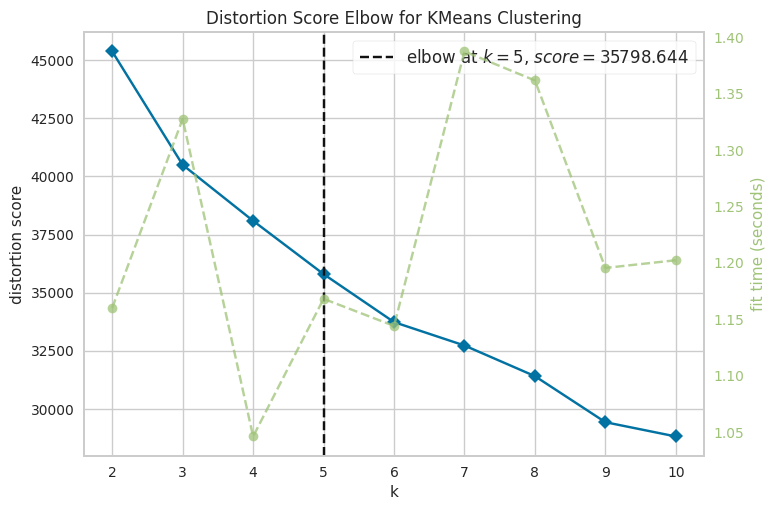

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

print("Elbow Method to determine the number of clusters to be formed:")
elbow = KElbowVisualizer(KMeans(), k = 10)
elbow.fit(df1_reduced)
elbow.show()

The inertia is not a good performance metric when trying to choose K. Because it keeps getting lower as we increase K. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. This technique for choosing the best value for the number of clusters is rather coarse.

A more precise (but also more computationally expensive) approach is to use the **silhouette score**.

The silhouette score is a metric used to evaluate the quality of clusters in unsupervised learning, including clustering algorithms like K-means. It provides a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

**Near +1**: The sample is far away from the neighboring clusters, indicating it is well-clustered.

**0**: The sample is on or very close to the decision boundary between two neighboring clusters.

**Near -1**: The sample may be assigned to the wrong cluster.

The number of clusters that maximizes the silhouette score is often considered the best choice.

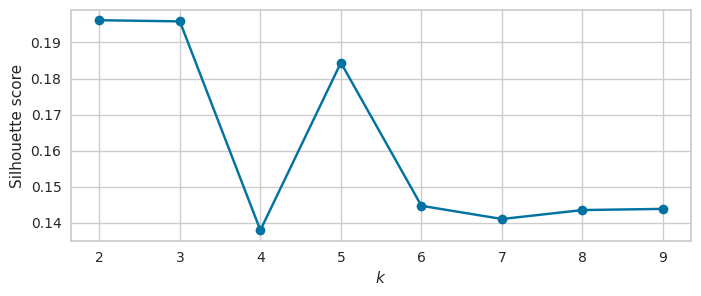

In [46]:
from sklearn.metrics import silhouette_score

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(df1_reduced)
                for k in range(2, 11)]

silhouette_scores = [silhouette_score(df1_reduced, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")

plt.grid(True)

plt.show()

In [47]:
# Print Silhouette score for each cluster

cluster_range = range(2, 10)
for i, score in zip(cluster_range, silhouette_scores):
  print(f"Silhouette Score for {i} Clusters:", score)

Silhouette Score for 2 Clusters: 0.1961813614561453
Silhouette Score for 3 Clusters: 0.19586103162072618
Silhouette Score for 4 Clusters: 0.1378820492978135
Silhouette Score for 5 Clusters: 0.18438442549172065
Silhouette Score for 6 Clusters: 0.14466450647465404
Silhouette Score for 7 Clusters: 0.14099551425161408
Silhouette Score for 8 Clusters: 0.1434789282165844
Silhouette Score for 9 Clusters: 0.14380902011838484


Silhouette score for 2 and 3 Clusters are nearly same (0.196)

Silhouette score for 5 Clusters are 0.184

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a **silhouette diagram.** Each diagram contains one knife shape per cluster. The shape's height indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better).

The vertical dashed lines represent the mean silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score, then the cluster is rather bad since this means its instances are much too close to other clusters.

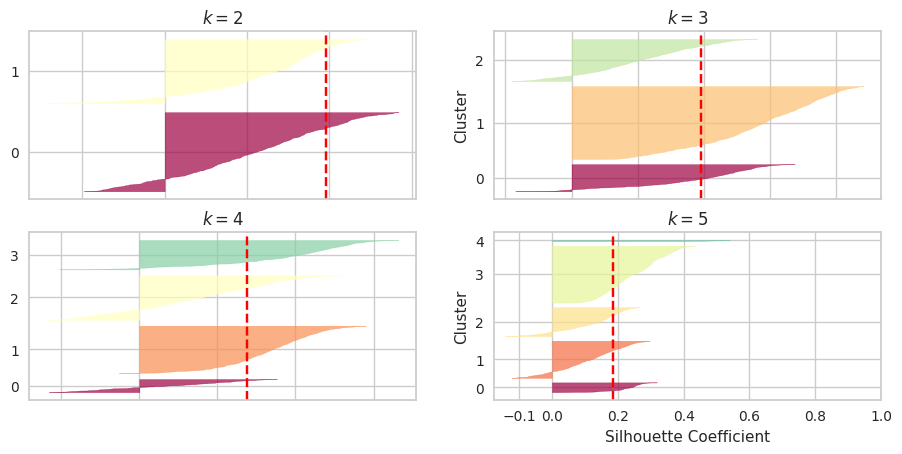

In [48]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 10))

for k in (2, 3, 4, 5):
    plt.subplot(4, 2, k - 1)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df1_reduced, y_pred)

    padding = len(df1_reduced) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

**Cluster Image for K=2**

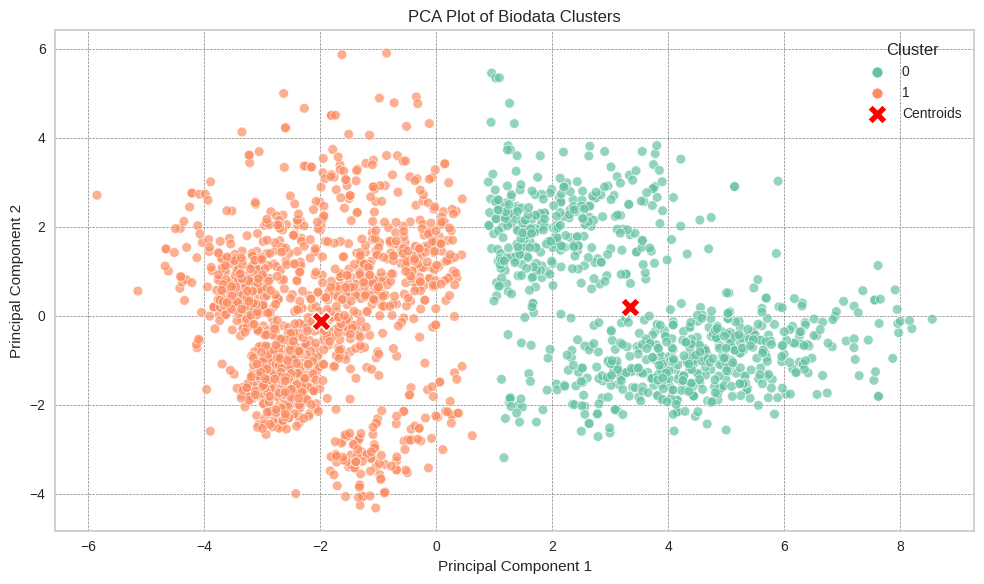

**Cluster Image for K=3**

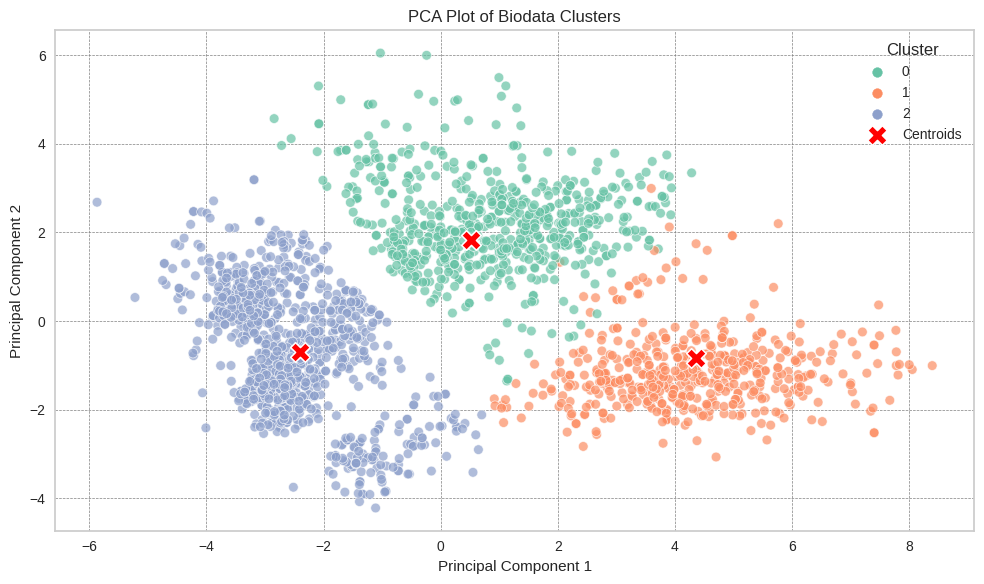

From Silhouette score, we will choose optimal number of clusters 2 or 3 or 5.

From Silhouette Diagram, we can see that for K=5, the 4th cluster has very less number of instances. Therefore we will not choose K=5.

For K=3, we can see that clusters have uneven number of instances. Therefore we will not choose K=3.

Also from cluster Images, we can see that, for K=3, some instances of 1st cluster is inside the boundary of 0th cluster. (means both clusters boundary is overlapping). And for K=2, all cluster's boundary is separate.

**Code for Cluster Image**   **(Optional)**

Just Remove "#" from code line.

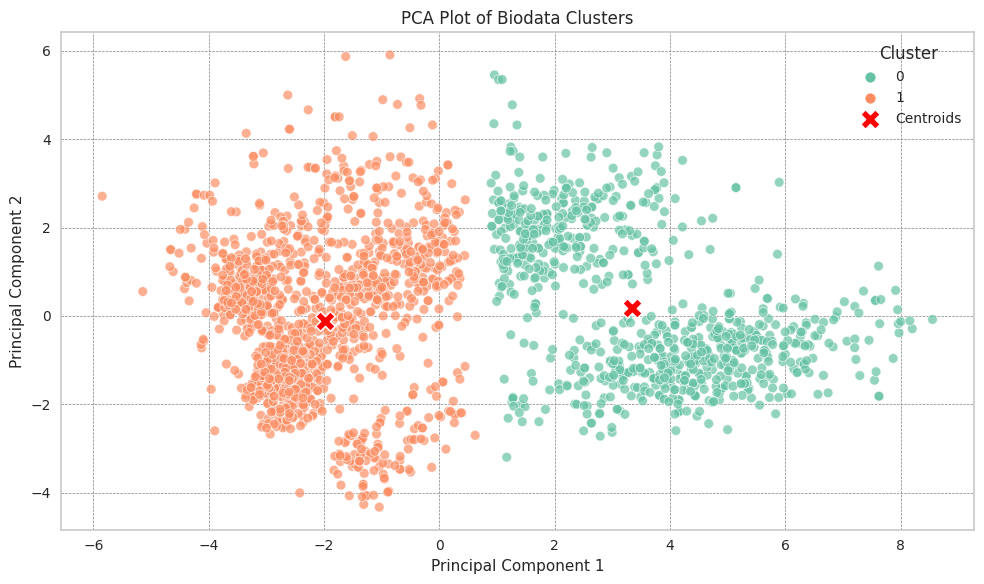

In [49]:
# Cluster Image

kmeans = KMeans(n_clusters= 2, random_state=42)  #change value of n_clusters
cluster_labels = kmeans.fit_predict(df1_reduced)
df1['Cluster'] = cluster_labels
df1.to_excel('Clustered_data.xlsx', index = False)


df2 = pd.read_excel('Clustered_data.xlsx')

scaler1 = StandardScaler()
normalized_data = scaler1.fit_transform(df2)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

df2['PC1'] = pca_data[:, 0]
df2['PC2'] = pca_data[:, 1]


cluster_palette = sns.color_palette("Set2", n_colors = len(df2['Cluster'].unique()))

plt.figure(figsize = (10, 6))

sns.scatterplot(df2, x = 'PC1', y = 'PC2', hue = 'Cluster', palette = cluster_palette, alpha = 0.7)

plt.title("PCA Plot of Biodata Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.grid(True)
plt.tight_layout()


plt.legend(title="Cluster", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], marker = 'X', s = 200, color = 'red', label = 'Centroids')
plt.legend(title = 'Cluster')


plt.show()

**Apply KMeans algorithm with K=2**

In [50]:
kmeans = KMeans(n_clusters= 2, random_state=42)
cluster_labels = kmeans.fit_predict(df1_reduced)
df1['Cluster'] = cluster_labels
df1.to_excel('Clustered_data.xlsx', index = False)

In [51]:
df1.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Living_with,Children,Family_size,Is_parent,Cluster
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,57,1617,0,0,1,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,60,27,0,2,3,1,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,49,776,1,0,2,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,30,53,1,1,3,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,33,422,1,1,3,1,1


In [52]:
df['Cluster'] = cluster_labels
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Age_on_2014,Spent,Living_with,Children,Family_size,Is_parent,Cluster
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,57,1617,0,0,1,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,60,27,0,2,3,1,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,49,776,1,0,2,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,30,53,1,1,3,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,33,422,1,1,3,1,1


**Number of datas distributed in clusters**

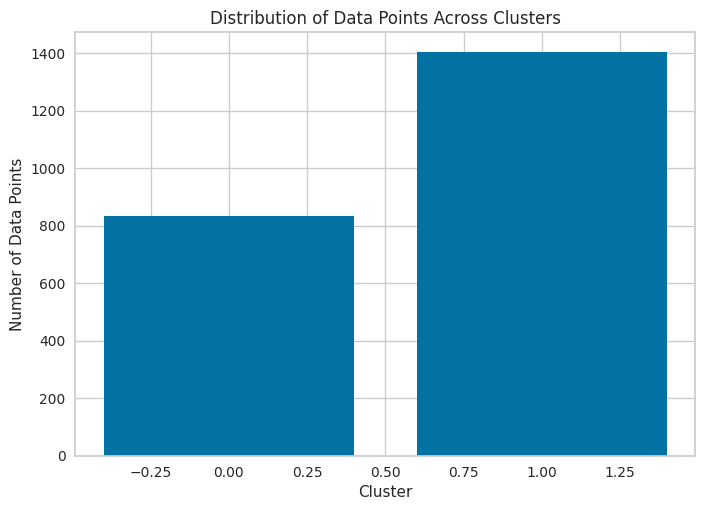

In [53]:
cluster_distribution = df['Cluster'].value_counts().sort_index()

plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Across Clusters')
plt.show()

**Analysis of Clusters**

**Cluster's Profile based on Income and Spending**

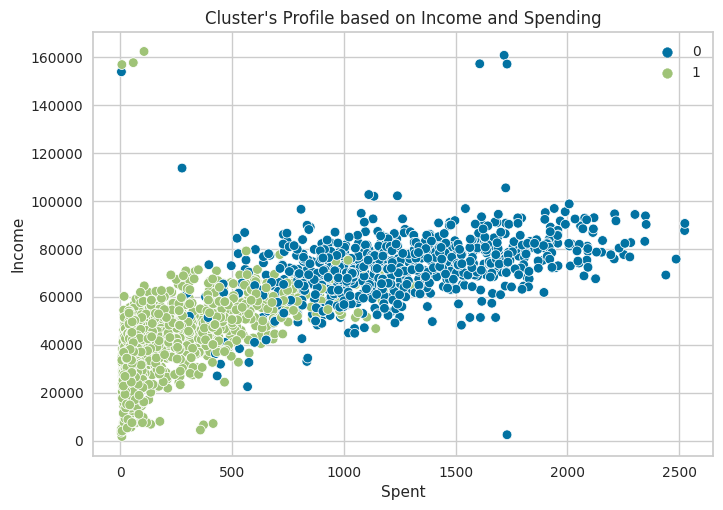

In [54]:
sns.scatterplot(df, x = 'Spent', y = 'Income', hue = 'Cluster')
plt.title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

**Cluster Pattern**
* Cluster 0: High spending and High Income
* Cluster 1: Low spending and average to low income

**Boxplot for spent according to cluster**

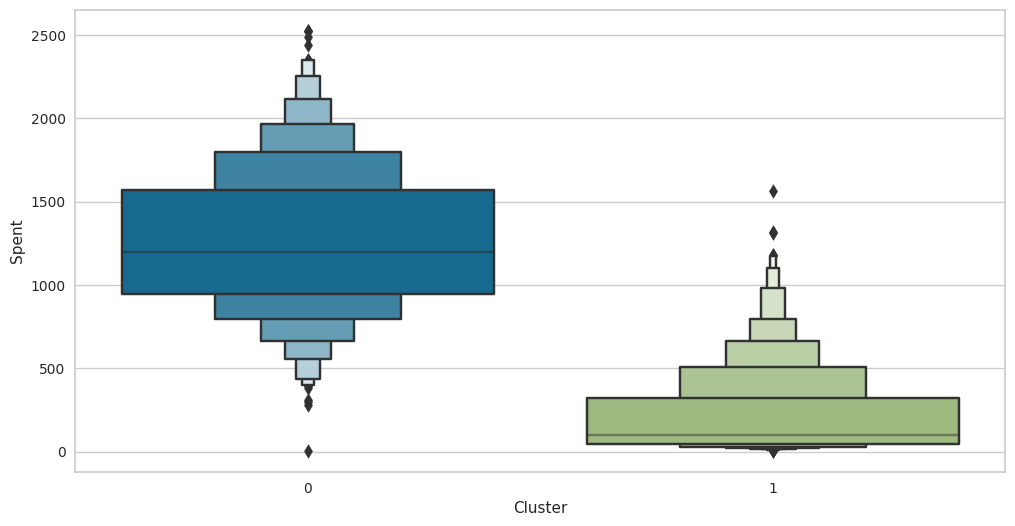

In [55]:
plt.figure(figsize = (12, 6))
sns.boxenplot(df, x = 'Cluster', y = 'Spent')

plt.show()

**Explore how did our campaigns do in the past**

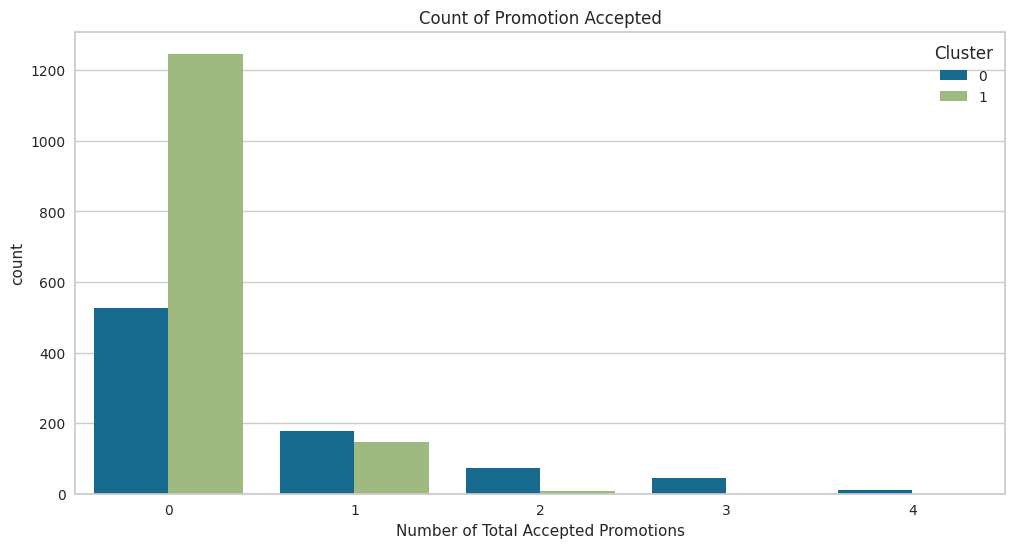

In [56]:
df['Total_promos'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

plt.figure(figsize = (12, 6))
sns.countplot(df, x = 'Total_promos', hue = 'Cluster')
plt.title("Count of Promotion Accepted")
plt.xlabel("Number of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one take part in all 5 of them. Perhaps better targeted and well-planned campaigns are required to boost sales.

**Number of Deals Purchased according to cluster**

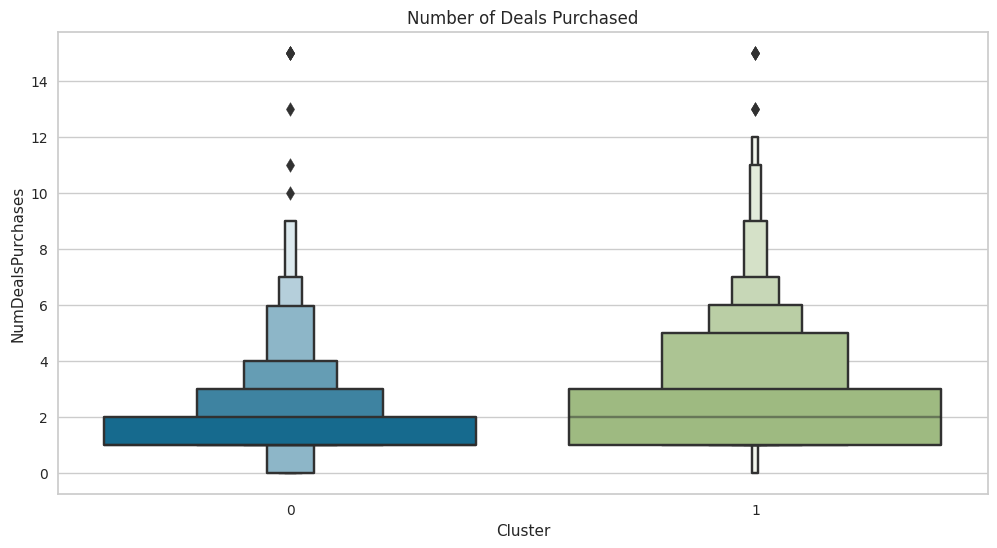

In [57]:
plt.figure(figsize = (12, 6))
sns.boxenplot(df, x = 'Cluster', y = 'NumDealsPurchases')
plt.title("Number of Deals Purchased")
plt.show()

Our star customers (cluster 0) are not much into the deals.

<Figure size 1200x600 with 0 Axes>

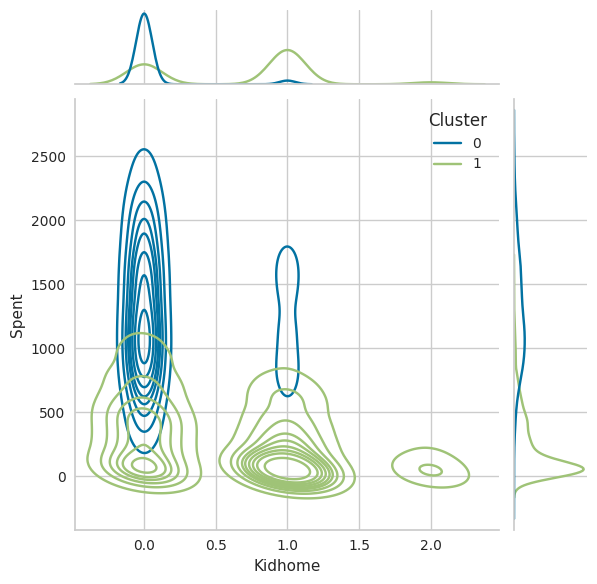

<Figure size 1200x600 with 0 Axes>

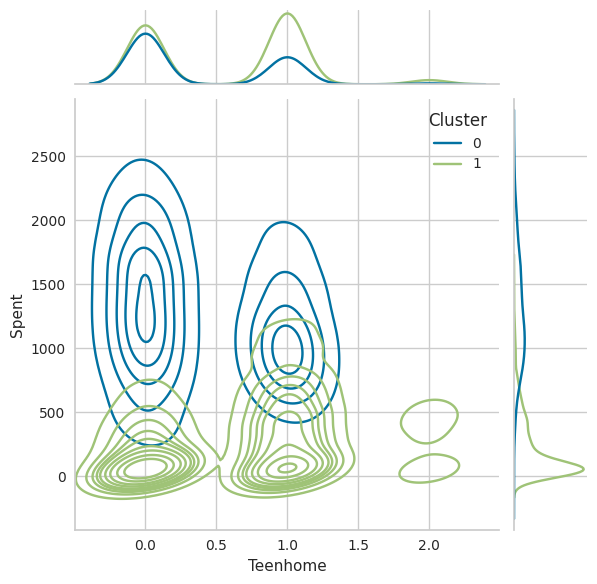

<Figure size 1200x600 with 0 Axes>

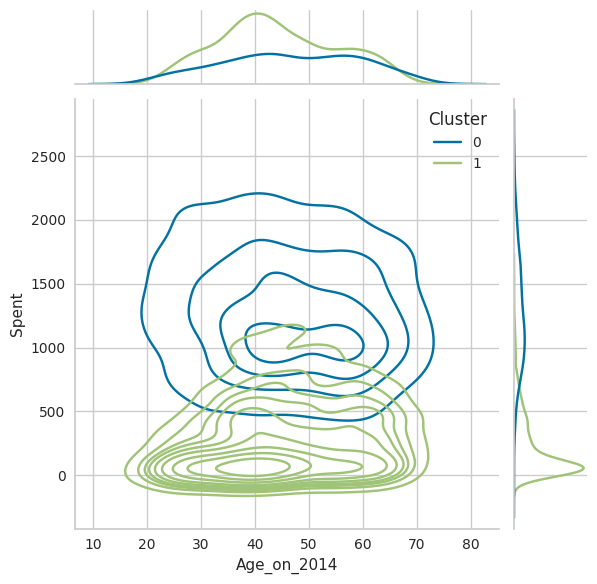

<Figure size 1200x600 with 0 Axes>

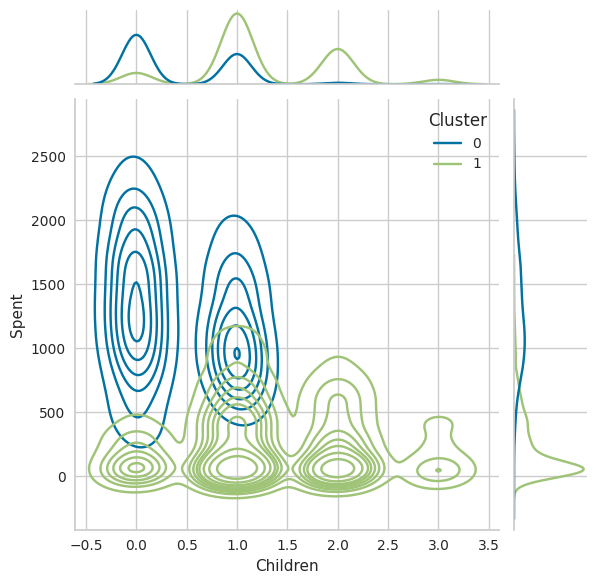

<Figure size 1200x600 with 0 Axes>

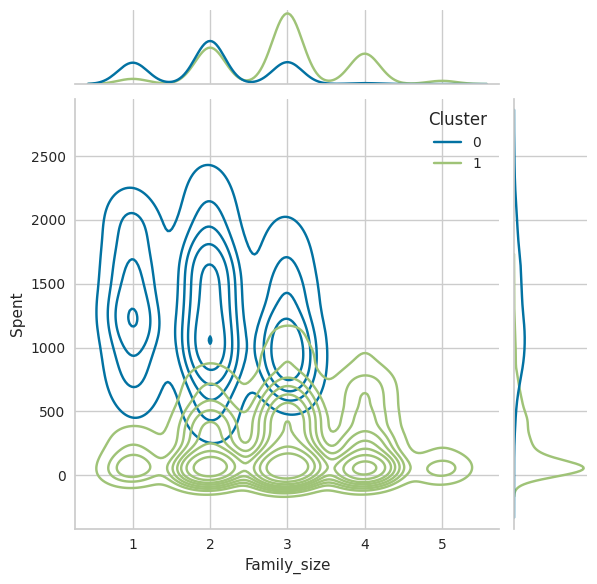

<Figure size 1200x600 with 0 Axes>

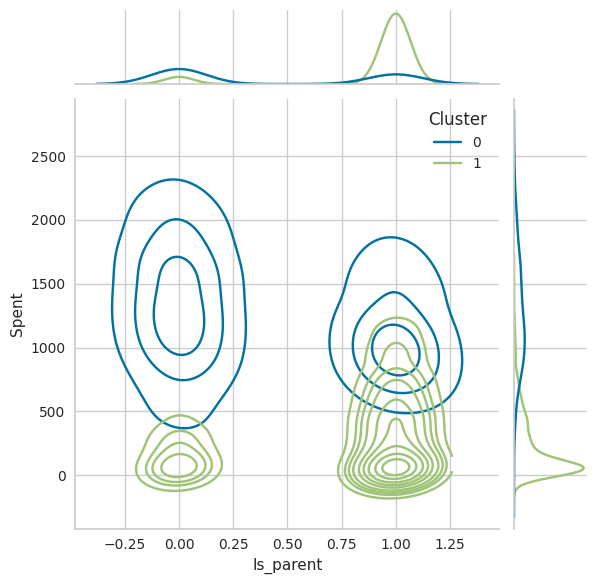

<Figure size 1200x600 with 0 Axes>

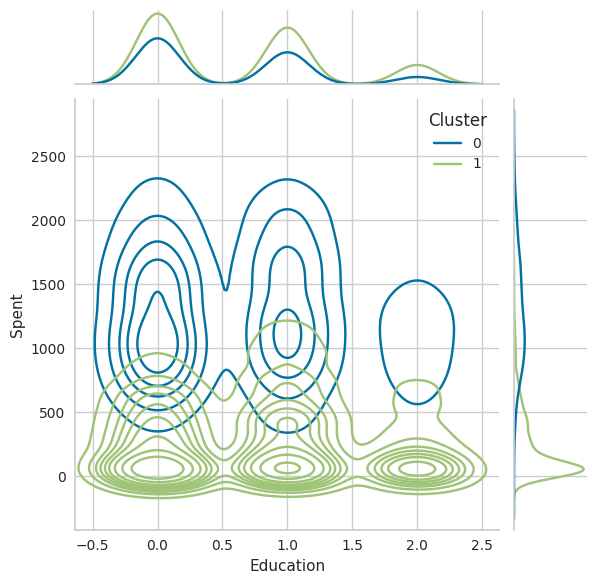

<Figure size 1200x600 with 0 Axes>

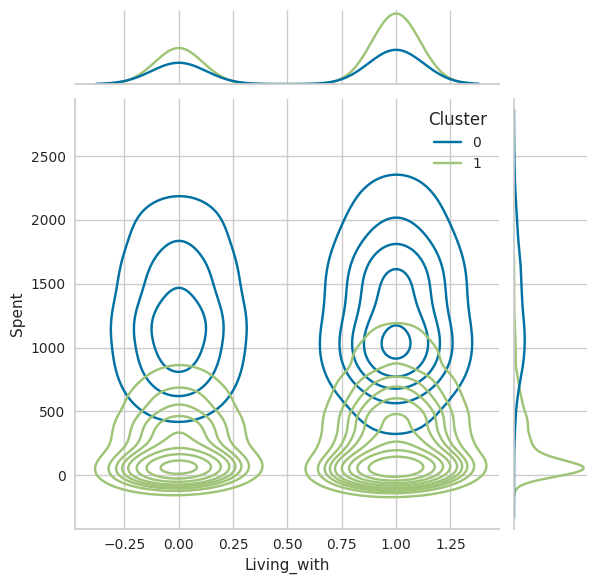

In [58]:
Personal = ['Kidhome', 'Teenhome', 'Age_on_2014', 'Children', 'Family_size', 'Is_parent', 'Education', 'Living_with']

for i in Personal:
  plt.figure(figsize = (12, 6))
  sns.jointplot(x = df[i], y = df['Spent'], hue = df['Cluster'], kind = 'kde')
  plt.show()